In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.metrics import r2_score
import torch

import matplotlib as mpl
%matplotlib inline
mpl.rc_file_defaults()

In [9]:
basedir = "../results/cinic_example/"
ind_prob_paths = [
    os.path.join(basedir, basename)
    for basename in os.listdir(basedir)
    if "base_wideresnet28_10ind_preds" in basename
]
# basedir = "../models/cinic_wrn28_10/"
ood_prob_paths = [
    os.path.join(basedir, basename)
    for basename in os.listdir(basedir)
    if "base_wideresnet28_10ood_cinic_preds" in basename
]
num_classes = 10

In [10]:
ind_probs = torch.stack([
    torch.tensor(np.load(ind_prob_path)).float()
    for ind_prob_path in ind_prob_paths
], dim=-2).softmax(dim=-1)
ind_labels = torch.tensor(np.load(ind_prob_paths[0].replace("preds", "labels"))).long()
ind_indices = torch.randperm(len(ind_probs))[:10000]

ood_probs = torch.stack([
    torch.tensor(np.load(ood_prob_path)).float()
    for ood_prob_path in ood_prob_paths
], dim=-2).softmax(dim=-1)
ood_labels = torch.tensor(np.load(ood_prob_paths[0].replace("preds", "labels"))).long()
ood_indices = torch.randperm(len(ood_probs))[:10000]

In [11]:
ind_ef2 = ind_probs[ind_indices].pow(2).sum(dim=-1).mean(dim=-1)
ood_ef2 = ood_probs[ood_indices].pow(2).sum(dim=-1).mean(dim=-1)

In [12]:
ind_var = ind_probs[ind_indices].var(dim=-2).sum(dim=-1)
ood_var = ood_probs[ood_indices].var(dim=-2).sum(dim=-1)

In [13]:
ind_ef2_kde = gaussian_kde(ind_ef2, bw_method=len(ind_indices) ** (-.25))
ood_ef2_kde = gaussian_kde(ood_ef2, bw_method=len(ood_indices) ** (-.25))

In [14]:
ind_joint_kde = gaussian_kde(np.stack([ind_ef2, ind_var]), bw_method=len(ind_indices) ** (-.25))
ood_joint_kde = gaussian_kde(np.stack([ood_ef2, ood_var]), bw_method=len(ood_indices) ** (-.25))

In [15]:
xs = np.linspace(0., 1., 101)
x_grid, y_grid = np.meshgrid(xs, xs)
joint = np.stack([x_grid.reshape(-1), y_grid.reshape(-1)])

In [16]:
import gpytorch

class GPModel(gpytorch.models.ExactGP):
    def __init__(self, metrics, variances):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(metrics, variances, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        self.covar_module.initialize(lengthscale=(len(variances) ** (-.25)))
        self.likelihood.initialize(noise=1e-4)
        
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)


ind_model = GPModel(ind_ef2.double(), ind_var.double()).double()
ood_model = GPModel(ood_ef2.double(), ood_var.double()).double()
ind_model.eval()
ood_model.eval()

start_conf = 1. / num_classes
cond_expec_xs = torch.linspace(start_conf, 1., int((1. - start_conf) * 100) + 1)
with torch.no_grad(), gpytorch.settings.skip_posterior_variances():
    with gpytorch.settings.max_cholesky_size(1e6):
        ind_cond_expec = ind_model(torch.tensor(cond_expec_xs).double()).mean
        ood_cond_expec = ood_model(torch.tensor(cond_expec_xs).double()).mean

/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_97845/3418621247.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ind_cond_expec = ind_model(torch.tensor(cond_expec_xs).double()).mean
/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_97845/3418621247.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ood_cond_expec = ood_model(torch.tensor(cond_expec_xs).double()).mean


In [17]:
fig, (var_ax, ind_cond_ax, ood_cond_ax, cond_exp_ax) = plt.subplots(
    1, 4, figsize=(12, 3), sharex=True, sharey=False
)
levels = np.linspace(-3., 3., 51)

sns.kdeplot(ind_var, ax=var_ax)
sns.kdeplot(ood_var, ax=var_ax)
var_ax.set(xlabel="Var.", title="Marginal Var. Dist.\nComparison", ylim=(0., 15.))

ind_vals = ind_joint_kde(joint).reshape(x_grid.shape)
ind_vals = ind_vals / ind_ef2_kde(x_grid.ravel()).reshape(x_grid.shape)
ind_vals = np.where(x_grid < (1. / num_classes), 0., ind_vals)
f = ind_cond_ax.contourf(
    x_grid, y_grid, ind_vals.clip(0., 10.),
    cmap="Blues",
    levels=np.linspace(0., 10., 50),
)
ind_cond_ax.set(
    xlim=(0., 1.), ylim=(0., 1.), xlabel=r"Avg. Conf. ($ E[ \Vert f \Vert^2 ]$)",
    ylabel=r"Variance", title="Conditional Var. Dist.\nCIFAR10 (InD)"
)
fig.colorbar(f, ax=ind_cond_ax)

ood_vals = ood_joint_kde(joint).reshape(x_grid.shape)
ood_vals = ood_vals / ood_ef2_kde(x_grid.ravel()).reshape(x_grid.shape)
ood_vals = np.where(x_grid < (1. / num_classes), 0., ood_vals)
f = ood_cond_ax.contourf(
    x_grid, y_grid, ood_vals.clip(0., 10.),
    cmap="Oranges",
    levels=np.linspace(0., 10., 50),
)
ood_cond_ax.set(
    xlabel=r"Avg. Conf. ($ E[ \Vert f \Vert^2 ]$)",
    title="Conditional Var. Dist.\nCINIC10 (OOD)",
    yticks=[]
)
fig.colorbar(f, ax=ood_cond_ax)

cond_exp_ax.plot(cond_expec_xs, ind_cond_expec, label="CIFAR10 (InD)")
cond_exp_ax.plot(cond_expec_xs, ood_cond_expec, label="CINIC10 (OOD)")
cond_exp_ax.set(
    ylim=(0., 1.), ylabel=r"$E [ \textrm{Var} \mid \textrm{Conf} ]$",
    xlabel=r"Avg. Conf. ($ E[ \Vert f \Vert^2 ]$)",
    title="Conditionally Expected Var.\nComparison"
)
cond_exp_ax.legend(loc="best")
fig.tight_layout()

ValueError: 
E [ \textrm{Var} \mid \textrm{Conf} ]
    ^
Unknown symbol: \textrm, found '\'  (at char 4), (line:1, col:5)

ValueError: 
E [ \textrm{Var} \mid \textrm{Conf} ]
    ^
Unknown symbol: \textrm, found '\'  (at char 4), (line:1, col:5)

<Figure size 1200x300 with 6 Axes>

In [33]:
model_indices = torch.tensor([
    [0, 1, 2, 3],
    [1, 2, 3, 4],
    [2, 3, 4, 0],
    [3, 4, 0, 1],
    [4, 0, 1, 2]
])
bs_ind_vars = (ind_probs[ind_indices].permute(1, 0, 2)[model_indices].
               var(dim=-3).sum(dim=-1).mean(dim=-1))
bs_ood_vars = (ood_probs[ood_indices].permute(1, 0, 2)[model_indices].
               var(dim=-3).sum(dim=-1).mean(dim=-1))
bs_ind_vars, bs_ood_vars

(tensor([0.0173, 0.0174, 0.0172, 0.0174, 0.0175]),
 tensor([0.0718, 0.0694, 0.0709, 0.0698, 0.0696]))

[0.017362209036946297, 0.07027702778577805]


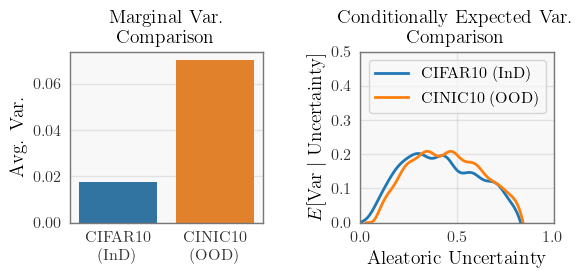

In [45]:
fig, (var_ax, cond_exp_ax) = plt.subplots(
    1, 2, figsize=(6, 3), sharex=False, sharey=False
)
print([ind_var.mean().item(), ood_var.mean().item()])
sns.barplot(x=["CIFAR10\n(InD)", "CINIC10\n(OOD)"], y=[ind_var.mean().item(), ood_var.mean().item()], ax=var_ax)
var_ax.set(ylabel="Avg. Var.", title="Marginal Var.\nComparison")

cond_exp_ax.plot(1. - cond_expec_xs, ind_cond_expec, label="CIFAR10 (InD)")
cond_exp_ax.plot(1. - cond_expec_xs, ood_cond_expec, label="CINIC10 (OOD)")
cond_exp_ax.set(
    ylim=(0., 0.5), xlim=(0., 1.),
    ylabel=r"$E [ \textrm{Var} \mid \textrm{Uncertainty} ]$",
    xlabel=r"Aleatoric Uncertainty",
    title="Conditionally Expected Var.\nComparison"
)
cond_exp_ax.legend(loc="best")
fig.tight_layout()
fig.subplots_adjust(wspace=0.5)
fig.savefig("conditional_fig_talk.pdf", transparent=True)

In [12]:
# xs = torch.rand(20).mul(5.).sort()[0]
# model = GPModel(xs, torch.randn(xs.size(0)))
# model.eval()
# with torch.no_grad(), gpytorch.settings.prior_mode():
#     ys = model(xs).rsample()
# plt.plot(xs, ys)

In [13]:
# model = GPModel(xs, ys)
# model.eval()

# ind_xs = torch.linspace(0., 5., 2000)
# ood_xs = torch.linspace(-5., 0., 2000)
# model.eval()
# with torch.no_grad():
#     preds = model(torch.cat([ood_xs, ind_xs]))
#     lower, upper = preds.confidence_region()
#     ind_var = model(ind_xs).variance
#     ood_var = model(ood_xs).variance
    
# plt.fill_between(torch.cat([ood_xs, ind_xs]), lower, upper, alpha=0.3)
# plt.plot(torch.cat([ood_xs, ind_xs]), preds.mean)

In [14]:
# ind_noise = torch.sin(ind_xs * 4).pow(2.).mul(2.).add(1e-2)
# ood_noise = torch.sin(ood_xs * 4).pow(2.).mul(2.).add(1e-2)

In [15]:
# ind_test_model = GPModel((ind_noise).double(), ind_var.double()).double()
# ood_test_model = GPModel((ood_noise).double(), ood_var.double()).double()
# ind_test_model.eval()
# ood_test_model.eval()

# cond_expec_xs = torch.linspace(0., 2., 101)
# with torch.no_grad(), gpytorch.settings.skip_posterior_variances():
#     with gpytorch.settings.max_cholesky_size(1e6):
#         ind_test_cond_expec = ind_test_model(torch.tensor(cond_expec_xs).double()).mean
#         ood_test_cond_expec = ood_test_model(torch.tensor(cond_expec_xs).double()).mean

In [16]:
# plt.plot(cond_expec_xs, ind_test_cond_expec)
# plt.plot(cond_expec_xs, ood_test_cond_expec)

In [17]:
# plt.scatter((ind_noise).double(), ind_var.double(), s=2)
# plt.scatter((ood_noise).double(), ood_var.double(), s=2)